# Imports and parameters

In [1]:
import os
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
from astropy.wcs import WCS
import numpy as np
import scipy.ndimage as ndimage
import emcee
import corner

import matplotlib
import matplotlib.pyplot as plt

from minot.ClusterTools import map_tools
from minot import model

# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

In [2]:
FWHM_planck = 10.0*u.arcmin
map_fov = 6*u.deg
map_reso = 1*u.arcmin
FWHM2sigma = 1.0/(2.0*np.sqrt(2*np.log(2)))

# Define a cluster object

In [3]:
clust = model.Cluster(name='Coma', redshift=0.023, M500=7e14*u.Msun, cosmology=cosmo, silent=True)
clust.coord = SkyCoord("194.953d  27.9806d", frame="icrs", unit="deg")

# To save outputs if requested
clust.output_dir = '/Users/adam/Desktop/test'

# We can check out the parameters
clust.print_param()

--- silent
    True
    <class 'bool'>
--- output_dir
    /Users/adam/Desktop/test
    <class 'str'>
--- cosmo
    FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)
    <class 'astropy.cosmology.core.FlatLambdaCDM'>
--- name
    Coma
    <class 'str'>
--- coord
    <SkyCoord (ICRS): (ra, dec) in deg
    (194.953, 27.9806)>
    <class 'astropy.coordinates.sky_coordinate.SkyCoord'>
--- redshift
    0.023
    <class 'float'>
--- D_ang
    98.96826080187294 Mpc
    <class 'astropy.units.quantity.Quantity'>
--- D_lum
    103.57315500872328 Mpc
    <class 'astropy.units.quantity.Quantity'>
--- M500
    700000000000000.0 solMass
    <class 'astropy.units.quantity.Quantity'>
--- R500
    1369.4682138780333 kpc
    <class 'astropy.units.quantity.Quantity'>
--- theta500
    0.7928273993781807 deg
    <class 'astropy.units.quantity.Quantity'>
--- R_truncation
    4108.4046416341 kpc
    <class 'astropy.units.quantity.Qu

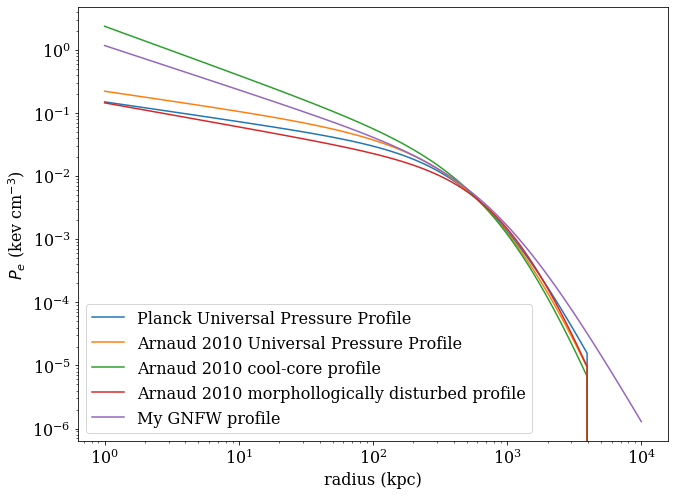

In [4]:
# How to change the pressure model
plt.figure(figsize=(10,8))

# We can use standard profiles based on mass and redshift
clust.set_pressure_gas_gNFW_param('P13UPP')
r, p_r = clust.get_pressure_gas_profile()
plt.loglog(r, p_r, label='Planck Universal Pressure Profile')

clust.set_pressure_gas_gNFW_param('A10UPP')
r, p_r = clust.get_pressure_gas_profile()
plt.loglog(r, p_r, label='Arnaud 2010 Universal Pressure Profile')

clust.set_pressure_gas_gNFW_param('A10CC')
r, p_r = clust.get_pressure_gas_profile()
plt.loglog(r, p_r, label='Arnaud 2010 cool-core profile')

clust.set_pressure_gas_gNFW_param('A10MD')
r, p_r = clust.get_pressure_gas_profile()
plt.loglog(r, p_r, label='Arnaud 2010 morphollogically disturbed profile')

# Note that we can redefine the truncation, e.g., no truncation, and define our own profile
clust.R_truncation = np.inf*u.kpc
clust.pressure_gas_model = {'name':'GNFW', 'P_0':1e-2*u.keV/u.cm**3, 'c500':1.5, 'a':1.3, 'b':3.7, 'c':0.7}
r, p_r = clust.get_pressure_gas_profile()
plt.loglog(r, p_r, label='My GNFW profile')

plt.xlabel('radius (kpc)')
plt.ylabel('$P_e$ (kev cm$^{-3}$)')
plt.legend()

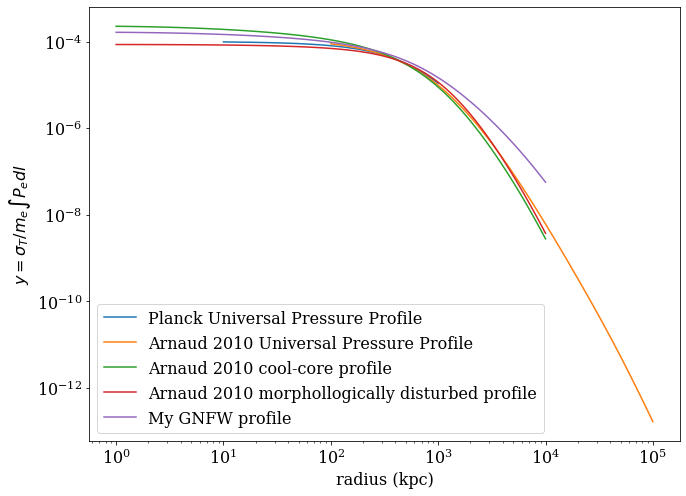

In [5]:
# How to derive the Compton parameter profile
plt.figure(figsize=(10,8))

clust.set_pressure_gas_gNFW_param('P13UPP')
# Note that we can pass a user defined radius
radius = np.logspace(1,3,1000)*u.kpc 
r, y_r = clust.get_sz_profile(radius, Compton_only=True)
plt.loglog(r, y_r, label='Planck Universal Pressure Profile')

# by default, the line of sight integration stops at 5R500, but we can change that
clust.set_pressure_gas_gNFW_param('A10UPP')
r, y_r = clust.get_sz_profile(np.logspace(2,5,1000)*u.kpc, NR500_los=30.0, Compton_only=True)
plt.loglog(r, y_r, label='Arnaud 2010 Universal Pressure Profile')

clust.set_pressure_gas_gNFW_param('A10CC')
r, y_r = clust.get_sz_profile(Compton_only=True)
plt.loglog(r, y_r, label='Arnaud 2010 cool-core profile')

clust.set_pressure_gas_gNFW_param('A10MD')
r, y_r = clust.get_sz_profile(Compton_only=True)
plt.loglog(r, y_r, label='Arnaud 2010 morphollogically disturbed profile')

clust.pressure_gas_model = {'name':'GNFW', 'P_0':1e-2*u.keV/u.cm**3, 'c500':1.5, 'a':1.3, 'b':3.7, 'c':0.7}
r, y_r = clust.get_sz_profile(Compton_only=True)
plt.loglog(r, y_r, label='My GNFW profile')

plt.xlabel('radius (kpc)')
plt.ylabel('$y = \\sigma_T/m_e \int P_e dl$')
plt.legend()

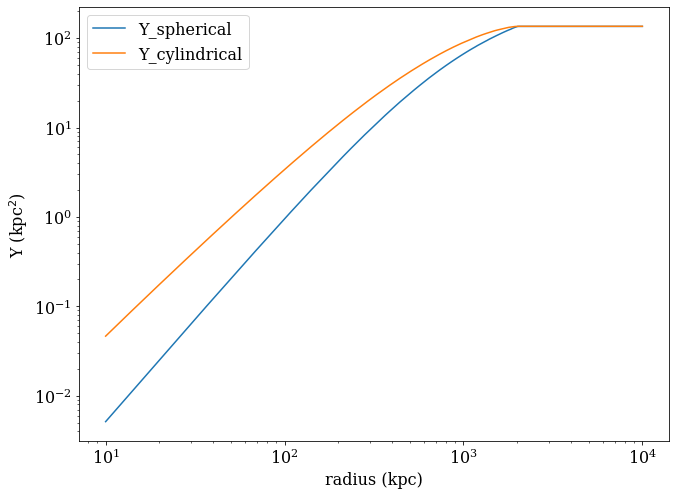

In [6]:
# How to derive the integrated profiles
clust.R_truncation = 2000*u.kpc
clust.pressure_gas_model = {'name':'GNFW', 'P_0':1e-2*u.keV/u.cm**3, 'c500':1.5, 'a':1.3, 'b':3.7, 'c':0.7}

plt.figure(figsize=(10,8))
radius = np.logspace(1,4,1000)*u.kpc 

# either the spherically integrated SZ flux
y_r = clust.get_sz_flux(Rmax=radius, Compton_only=True, type_integral='spherical')
plt.loglog(radius, y_r, label='Y_spherical')

# or the cylindrically integrated
y_r = clust.get_sz_flux(Rmax=radius, Compton_only=True, type_integral='cylindrical')
plt.loglog(radius, y_r, label='Y_cylindrical')

plt.xlabel('radius (kpc)')
plt.ylabel('Y (kpc$^2$)')
plt.legend()

# Note that because of truncation, the Y profile remain constant beyond R_truncation
# At r = infinity, the sphercial and cylindrical profile should converge

### Extract the Compton parameter map from Planck

In [7]:
# Lets first define the directory where we have put the Planck y_map
dat_dir = os.getenv('CTAPHYS_EDAT_DIR')
ymap_file  = dat_dir+'/Planck/COM_CompMap_Compton-SZMap-milca-ymaps_2048_R2.00.fits'

# We can play with the map size and resolution of our map
clust.map_fov = map_fov
clust.map_reso = map_reso

ymap, header = map_tools.roi_extract_healpix(ymap_file, clust.coord.ra.value, clust.coord.dec.value, 
                                   clust.map_reso.to_value('deg'), 
                                             [clust.map_fov[0].to_value('deg'), clust.map_fov[1].to_value('deg')],
                                             visu=False)

# We can also set the header of our model to a given map (to have pixel-pixel comparison)
clust.map_header = header

/Users/adam/Project/anaconda3/envs/env37/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/Users/adam/Project/anaconda3/envs/env37/lib/python3.7/site-packages/healpy/fitsfunc.py:426: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Text(0.5, 1.0, 'Coma Planck map, y x $10^6$')

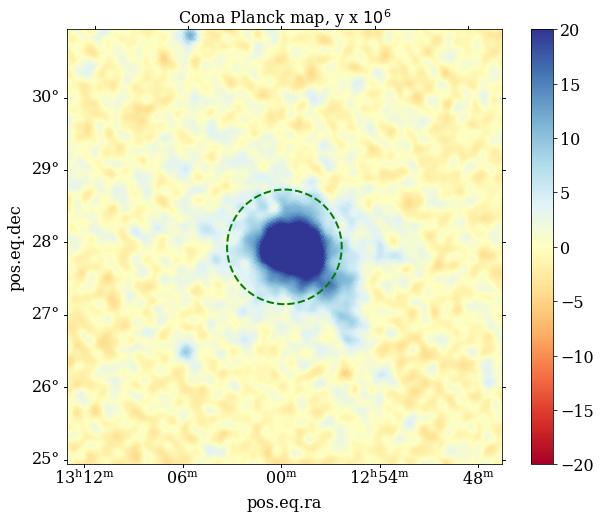

In [8]:
fig = plt.figure(figsize=(10, 8))
rad = clust.theta500.to_value('deg')
ax = plt.subplot(111, projection=WCS(header))
plt.imshow(1e6*ymap, vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((clust.coord.ra.value, clust.coord.dec.value),
                                        2*rad/np.cos(clust.coord.dec.value*np.pi/180), 2*rad,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.colorbar()
plt.title(clust.name+' Planck map, y x $10^6$')

# Compute a model ymap

In [9]:
# Let's get a ymap, and smooth it to the Planck Beam for comparison
ymodel = (clust.get_sz_map(Compton_only=True)).value
ymodel = ndimage.gaussian_filter(ymodel, sigma=FWHM2sigma*(FWHM_planck/map_reso).to_value(''), order=0)

Text(0.5, 1.0, 'Coma Model map, y x $10^6$')

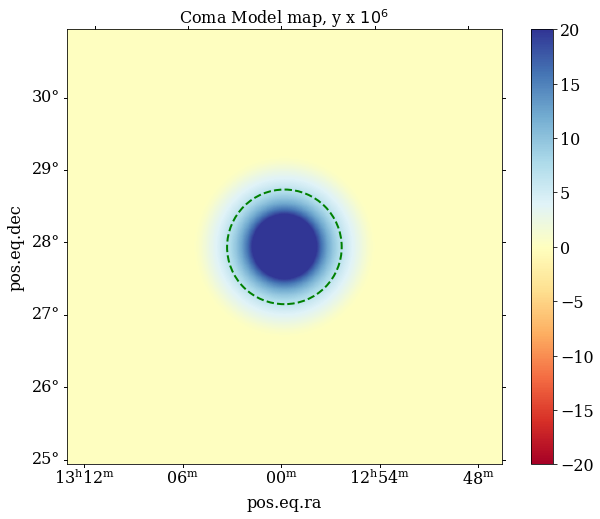

In [10]:
fig = plt.figure(figsize=(10, 8))
rad = clust.theta500.to_value('deg')
ax = plt.subplot(111, projection=WCS(header))
plt.imshow(1e6*ymodel, vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((clust.coord.ra.value, clust.coord.dec.value),
                                        2*rad/np.cos(clust.coord.dec.value*np.pi/180), 2*rad,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.colorbar()
plt.title(clust.name+' Model map, y x $10^6$')

Text(0.5, 1.0, 'Coma low mass model map, y x $10^6$')

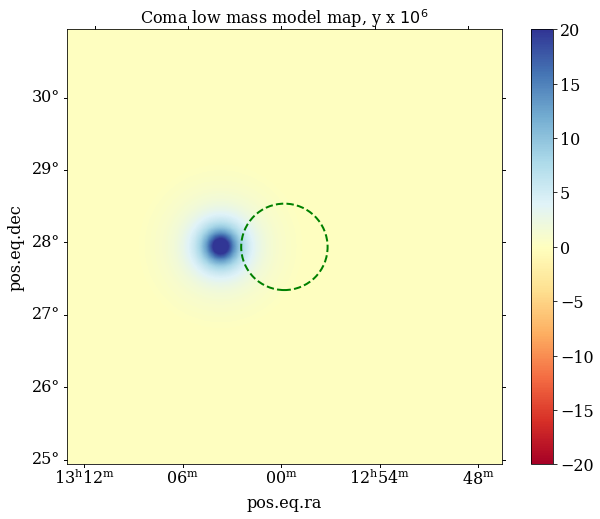

In [11]:
# Let see how the model affect the map by setting a low mass and using the UPP
clust.M500 = 3e14*u.Msun
clust.set_pressure_gas_gNFW_param('P13UPP')
clust.coord = SkyCoord(clust.coord.icrs.ra+1*u.deg, clust.coord.icrs.dec, frame='icrs')
ymodel = (clust.get_sz_map(Compton_only=True)).value
clust.coord = SkyCoord("194.953d  27.9806d", frame="icrs", unit="deg")
ymodel = ndimage.gaussian_filter(ymodel, sigma=FWHM2sigma*(FWHM_planck/map_reso).to_value(''), order=0)

fig = plt.figure(figsize=(10, 8))
rad = clust.theta500.to_value('deg')
ax = plt.subplot(111, projection=WCS(header))
plt.imshow(1e6*ymodel, vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((clust.coord.ra.value, clust.coord.dec.value),
                                        2*rad/np.cos(clust.coord.dec.value*np.pi/180), 2*rad,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.colorbar()
plt.title(clust.name+' low mass model map, y x $10^6$')

# MCMC fit of the parameters (amplitude and concentraction)

In [12]:
# Defines model
def model(clust, params):
    P_0  = params[0]
    c500 = params[1]
    
    clust.pressure_gas_model = {'name':'GNFW', 'P_0':P_0*u.keV/u.cm**3, 'c500':c500, 'a':1.8, 'b':3.1, 'c':0.0}

    ymod = (clust.get_sz_map(Compton_only=True)).value
    ymod = ndimage.gaussian_filter(ymod, sigma=FWHM2sigma*(FWHM_planck/map_reso).to_value(''), order=0)
    return ymod

# Defines log likelihood
def lnlike(params, clust, data, err) :
    cond1 = params[0]>0 and params[1]>0
    if cond1:
        mod = model(clust, params)
        chi2 = ((data - mod)**2) / (err**2)
        return -0.5*np.sum(chi2)
    else:
        return -np.inf

In [13]:
# Get the data, error, and initial parameters
clust.R500 = 1.31*u.Mpc # Since we fir for c500, R500 should be defined (from Planck2013 Coma paper)

data = ymap
err = ymap*0 + np.std(ymap) # First guess for errors
for i in [1,2,3,4,5,6]: err = ymap*0 + np.std(ymap[ymap/err < 5]) # Refine error, but still no covariance here
par0 = np.array([2.0e-2, 3.0]) # guess parameters

In [14]:
# Run the MCMC
ndim, nwalkers, nsteps, burnin = len(par0), 10, 2000, 500

nwalkers = 10
ndim = len(par0)
pos = [par0 + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=[clust, data, err], a=2.0, threads=2)
sampler.run_mcmc(pos, nsteps)

State([[0.02202126 2.84651342]
 [0.02227509 2.86298696]
 [0.02194679 2.84156625]
 [0.02198927 2.8425419 ]
 [0.02195332 2.84231042]
 [0.02207603 2.84980378]
 [0.02219958 2.85847456]
 [0.02201119 2.84531573]
 [0.02208239 2.85041106]
 [0.02222275 2.85789507]], log_prob=[-66790.12245614 -66791.62774621 -66790.62791611 -66790.28905587
 -66790.67289512 -66789.93855387 -66790.79493089 -66790.04252856
 -66789.99298048 -66790.8347616 ], blobs=None, random_state=('MT19937', array([3384510871, 1662280370, 2161336756, 1499546290, 2859465467,
       1385738474, 1541614076, 2605169230, 1765655541, 3772767622,
       3259018083, 3175762146, 2475676448,  126683651,  506250595,
       3912801885, 1805282680, 3788302080, 1846746208, 1081828964,
       2309603259, 3993021105, 2634672502, 2228734254,  394868510,
        351905751, 1395053616,  481185994, 1254525516,  454639745,
       2788250670, 3359596317,  584200718, 4107815665,  193480980,
       3609674826, 3091317986, 2130510774, 3759632012,  298574

In [15]:
# Burn in
param_chains = sampler.chain[:, burnin:, :]
lnL_chains = sampler.lnprobability[:, burnin:]

In [16]:
# Get the best fit parameters
wbest = (lnL_chains == np.amax(lnL_chains))
p0_best = ((param_chains[:,:,0])[wbest])[0]
c500_best = ((param_chains[:,:,1])[wbest])[0]

print(p0_best, c500_best)

0.02207255470368235 2.8488968660071805


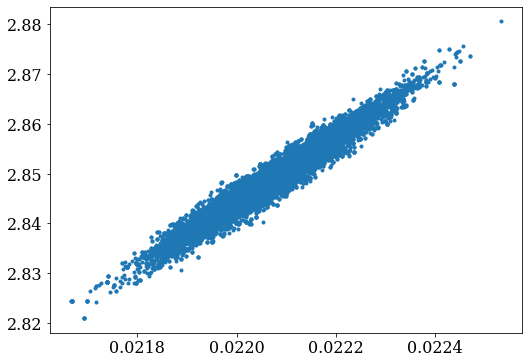

In [17]:
# Show the constraints
plt.plot(param_chains[:,:,0].flatten(), param_chains[:,:,1].flatten(), '.')

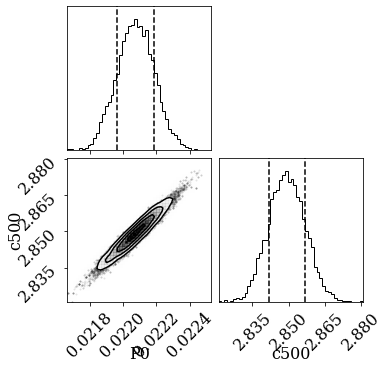

In [18]:
par_flat = param_chains.reshape(param_chains.shape[0]*param_chains.shape[1], param_chains.shape[2])
parname = ['P0', 'c500', 'RA', 'Dec']
fig = corner.corner(par_flat, bins=50, color='k', smooth=1,labels=parname, quantiles=(0.16, 0.84))

Text(0.5, 1.0, 'Coma, data - best fit model, y x $10^6$')

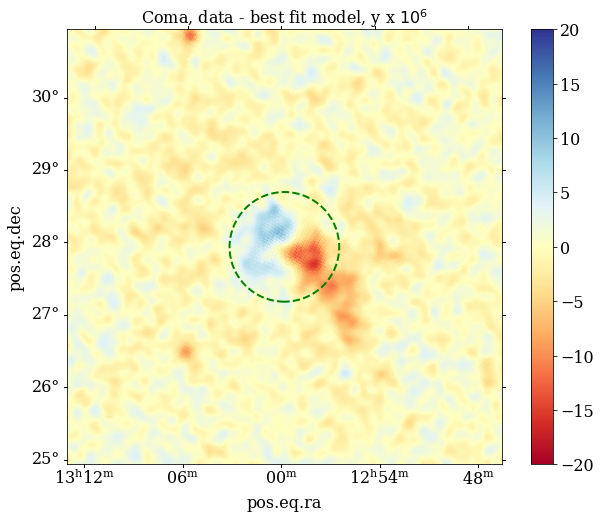

In [19]:
# Look at the residual map
ybest = model(clust, [p0_best, c500_best])

fig = plt.figure(figsize=(10, 8))
rad = clust.theta500.to_value('deg')
ax = plt.subplot(111, projection=WCS(header))
plt.imshow(1e6*(ybest-ymap), vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((clust.coord.ra.value, clust.coord.dec.value),
                                        2*rad/np.cos(clust.coord.dec.value*np.pi/180), 2*rad,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.colorbar()
plt.title(clust.name+', data - best fit model, y x $10^6$')

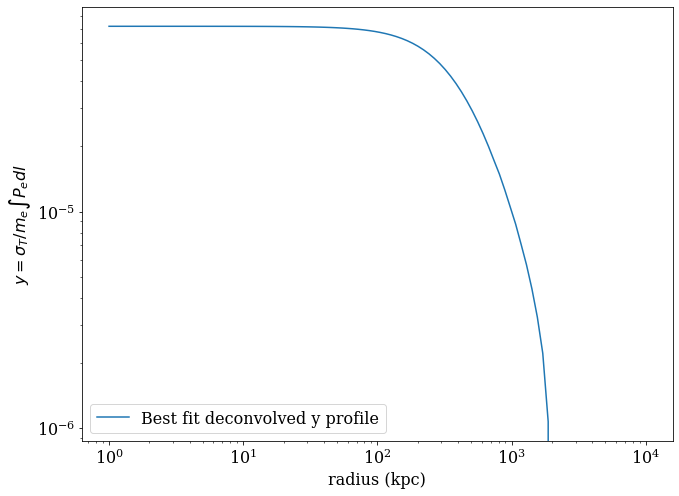

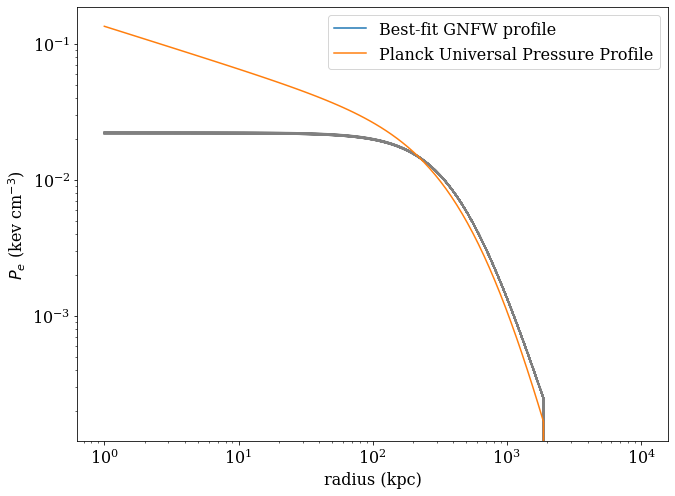

In [20]:
# How to derive the Pressure and Compton parameter profile
clust.pressure_gas_model = {'name':'GNFW', 'P_0':p0_best*u.keV/u.cm**3, 'c500':c500_best, 'a':1.8, 'b':3.1, 'c':0.0}

plt.figure(figsize=(10,8))
r, y_r = clust.get_sz_profile(Compton_only=True)
plt.loglog(r, y_r, label='Best fit deconvolved y profile')
plt.xlabel('radius (kpc)')
plt.ylabel('$y = \\sigma_T/m_e \int P_e dl$')
plt.legend()

plt.figure(figsize=(10,8))

r, p_r = clust.get_pressure_gas_profile()
plt.loglog(r, p_r, label='Best-fit GNFW profile')

chains = np.reshape(param_chains, (param_chains.shape[0]*param_chains.shape[1],param_chains.shape[2]))
w = (np.linspace(0,len(chains[:,0]), 100, dtype='int'))
for i in range(99):
    clust.pressure_gas_model = {'name':'GNFW', 'P_0':chains[w[i],0]*u.keV/u.cm**3, 'c500':chains[w[i],1], 'a':1.8, 'b':3.1, 'c':0.0}
    r, p_r = clust.get_pressure_gas_profile()
    plt.loglog(r, p_r, 'grey')

clust.set_pressure_gas_gNFW_param('P13UPP')
r, p_r = clust.get_pressure_gas_profile()
plt.loglog(r, p_r, label='Planck Universal Pressure Profile')

plt.xlabel('radius (kpc)')
plt.ylabel('$P_e$ (kev cm$^{-3}$)')
plt.legend()

In [4]:
(500000*73/0.05)/70e6

10.428571428571429